# BTC_Arb Trade & Market Analysis

This notebook provides a template for analyzing the performance of the BTC_Arb strategy and the underlying market microstructure data from ClickHouse DB using the Polybot infrastructure for live paper trading.

In [27]:
import clickhouse_connect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Set plot style
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

# Connect to ClickHouse
client = clickhouse_connect.get_client(host='localhost', port=8123, database='polybot')
print("Connected to ClickHouse")

Connected to ClickHouse


## 1. Latest BTC 15m Paper Trades

Let's fetch the recent fills for our strategy.

In [28]:
query = """
SELECT 
    ts, 
    market_slug, 
    outcome, 
    price, 
    size,
    price * size as volume_usd
FROM polybot.user_trades 
WHERE market_slug LIKE '%btc-updown-15m%'
ORDER BY ts DESC 
LIMIT 50
"""

trades_df = client.query_df(query)
trades_df.head(20)

,ts,market_slug,outcome,price,size,volume_usd
0,2026-01-23 08:32:12,btc-updown-15m-1769157000,Down,0.29,5.00,1.4500
1,2026-01-23 08:32:10,btc-updown-15m-1769157000,Up,0.71,11.26,7.9946
2,2026-01-23 08:31:56,btc-updown-15m-1769157000,Down,0.31,20.00,6.2000
3,2026-01-23 08:31:54,btc-updown-15m-1769157000,Up,0.68,11.76,7.9968
4,2026-01-23 08:31:52,btc-updown-15m-1769157000,Down,0.34,20.00,6.8000
5,2026-01-23 08:31:41,btc-updown-15m-1769157000,Down,0.35,20.00,7.0000
6,2026-01-23 08:31:38,btc-updown-15m-1769157000,Down,0.37,9.00,3.3300
7,2026-01-23 08:31:38,btc-updown-15m-1769157000,Down,0.36,20.00,7.2000
8,2026-01-23 08:31:38,btc-updown-15m-1769157000,Down,0.37,20.00,7.4000
9,2026-01-23 08:31:34,btc-updown-15m-1769157000,Down,0.38,20.00,7.6000


## 2. Order Submission Analysis

Verify how many orders the strategy is placing and their success rate.

In [21]:
order_stats_query = """
SELECT 
    exchange_status,
    count() as count,
    sum(matched_size) as total_shares
FROM polybot.executor_order_status
GROUP BY exchange_status
"""

stats_df = client.query_df(order_stats_query)
stats_df

,exchange_status,count,total_shares
0,CANCELED,1047,NaN
1,PARTIALLY_FILLED,44,142.96
2,OPEN,1458,NaN
3,FILLED,367,4297.99


## 3. Market Microstructure (Advanced)

If you want to see the order book spread at the time of your trades.

In [22]:
enriched_query = """
SELECT 
    ts, 
    market_slug, 
    price, 
    ws_mid, 
    ws_spread,
    (price - ws_mid) as slippage
FROM polybot.user_trade_enriched_v4
WHERE market_slug LIKE '%btc-updown-15m%'
ORDER BY ts DESC
LIMIT 100
"""

enriched_df = client.query_df(enriched_query)
enriched_df.head()

,ts,market_slug,price,ws_mid,ws_spread,slippage
0,2026-01-22 18:47:49,btc-updown-15m-1769107500,0.28,0.285,0.01,-0.005
1,2026-01-22 18:47:47,btc-updown-15m-1769107500,0.28,0.285,0.01,-0.005
2,2026-01-22 18:47:10,btc-updown-15m-1769107500,0.42,0.425,0.01,-0.005
3,2026-01-22 18:47:08,btc-updown-15m-1769107500,0.44,0.445,0.01,-0.005
4,2026-01-22 18:47:06,btc-updown-15m-1769107500,0.46,0.465,0.01,-0.005


## 5. Zero Arbitrage Pairs Analysis

Analyzing the cost of a complete set (Up + Down) to find arbitrage edge.

In [24]:
arb_query = """
SELECT 
    event_key,
    count(distinct outcome) as outcomes_traded,
    sum(price) as total_price_for_set,
    1.0 - sum(price) as manual_edge,
    sum(size) as total_shares,
    min(ts) as start_time
FROM polybot.user_trade_enriched_v4
GROUP BY event_key
HAVING outcomes_traded >= 1 -- Relaxed to see all trades; use = 2 for full arbs
ORDER BY start_time DESC
"""

arb_df = client.query_df(arb_query)

if not arb_df.empty and 'manual_edge' in arb_df.columns:
    display(arb_df.head(20))
    print(f"Average Edge Captured: {arb_df['manual_edge'].mean():.4f}")
else:
    print("No arbitrage data found for current filters.")

,event_key,outcomes_traded,total_price_for_set,manual_edge,total_shares,start_time
0,simtrade:sim-2dc71abe-788c-487d-afe8-bb62b2f75...,1,0.08,0.92,0.01,2026-01-22 18:47:50
1,simtrade:sim-116777b3-d003-4328-ac9b-1dc3939f3...,1,0.28,0.72,9.56,2026-01-22 18:47:49
2,simtrade:sim-c8773432-c0a5-4976-bb4d-d801b5c98...,1,0.28,0.72,9.56,2026-01-22 18:47:47
3,simtrade:sim-23d3fbf5-8512-449a-94d7-65d129ff3...,1,0.68,0.32,11.76,2026-01-22 18:47:14
4,simtrade:sim-516f97f2-ba29-4798-8609-298f200a0...,1,0.50,0.50,14.00,2026-01-22 18:47:10
5,simtrade:sim-df18811e-0ccb-4705-9db6-cc532ebe2...,1,0.15,0.85,11.00,2026-01-22 18:47:10
6,simtrade:sim-71a446ca-a9ee-48ea-a39e-a401ffca9...,1,0.42,0.58,4.19,2026-01-22 18:47:10
7,simtrade:sim-c79db103-7212-4f9b-ba5b-03927ab16...,1,0.85,0.15,2.60,2026-01-22 18:47:09
8,simtrade:sim-9e2d652c-524c-4e1d-b4f4-4322b88e2...,1,0.69,0.31,11.59,2026-01-22 18:47:09
9,simtrade:sim-235b5820-4920-4cbf-8469-bd1a0c7d1...,1,0.44,0.56,9.51,2026-01-22 18:47:08


Average Edge Captured: 0.5068


## 6. Losing Trades Identification

Detailed look at individual trades that lost money.

In [25]:
losing_trades_query = """
SELECT 
    ts, 
    market_slug, 
    side, 
    outcome, 
    price, 
    settle_price, 
    realized_pnl,
    price - ws_mid as slippage,
    seconds_to_end
FROM polybot.user_trade_enriched_v4
WHERE realized_pnl < 0
ORDER BY realized_pnl ASC
LIMIT 20
"""

losers_df = client.query_df(losing_trades_query)
if not losers_df.empty:
    display(losers_df)
else:
    print("No losing trades found in the current dataset.")

No losing trades found in the current dataset.


## 7. Cumulative Equity Curve

visualizing performance over time.

In [29]:
equity_query = """
SELECT 
    ts, 
    realized_pnl
FROM polybot.user_trade_enriched_v4
WHERE is_resolved = 1
ORDER BY ts ASC
"""

equity_df = client.query_df(equity_query)
equity_df['cum_pnl'] = equity_df['realized_pnl'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(equity_df['ts'], equity_df['cum_pnl'], label='Cumulative Realized P&L', color='blue')
plt.axhline(0, color='black', linestyle='--', alpha=0.3)
plt.title('Strategy Equity Curve')
plt.xlabel('Time')
plt.ylabel('PnL (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

KeyError: 'realized_pnl'

## 6. Gabagool Targeted Run Analysis

Detailed analysis of the 5-minute targeted Gabagool run on BTC 15m markets.

In [30]:
gabagool_query = """
SELECT 
    ts, 
    market_slug, 
    side, 
    price, 
    size,
    ws_exec_type as exec_type,
    ws_complete_set_edge_ask as edge
FROM polybot.user_trade_enriched_v4
WHERE ts > '2026-01-23 08:25:00'
ORDER BY ts DESC
"""

gabagool_df = client.query_df(gabagool_query)

if not gabagool_df.empty:
    print(f"Total Trades in Run: {len(gabagool_df)}")
    display(gabagool_df.head(10))
    
    # Maker vs Taker split
    if 'exec_type' in gabagool_df.columns:
        exec_split = gabagool_df['exec_type'].value_counts(normalize=True) * 100
        print("\nExecution Type Split:")
        print(exec_split)
else:
    print("No trades found in the specified window.")

Total Trades in Run: 102


,ts,market_slug,side,price,size,exec_type,edge
0,2026-01-23 08:32:49,btc-updown-15m-1769157000,BUY,0.60,3.13,MAKER_LIKE,NaN
1,2026-01-23 08:32:48,btc-updown-15m-1769157000,BUY,0.39,20.00,MAKER_LIKE,NaN
2,2026-01-23 08:32:47,btc-updown-15m-1769157000,BUY,0.39,4.37,MAKER_LIKE,NaN
3,2026-01-23 08:32:47,btc-updown-15m-1769157000,BUY,0.39,19.50,MAKER_LIKE,NaN
4,2026-01-23 08:32:46,btc-updown-15m-1769157000,BUY,0.39,18.60,TAKER_LIKE,NaN
5,2026-01-23 08:32:45,btc-updown-15m-1769157000,BUY,0.39,4.37,MAKER_LIKE,NaN
6,2026-01-23 08:32:44,btc-updown-15m-1769157000,BUY,0.38,18.60,MAKER_LIKE,NaN
7,2026-01-23 08:32:43,btc-updown-15m-1769157000,BUY,0.38,19.04,TAKER_LIKE,NaN
8,2026-01-23 08:32:42,btc-updown-15m-1769157000,BUY,0.38,19.51,MAKER_LIKE,NaN
9,2026-01-23 08:32:41,btc-updown-15m-1769157000,BUY,0.38,20.00,MAKER_LIKE,NaN



Execution Type Split:
exec_type
MAKER_LIKE    54.901961
TAKER_LIKE    42.156863
INSIDE         2.941176
Name: proportion, dtype: double[pyarrow]


Average Complete Set Edge: nan


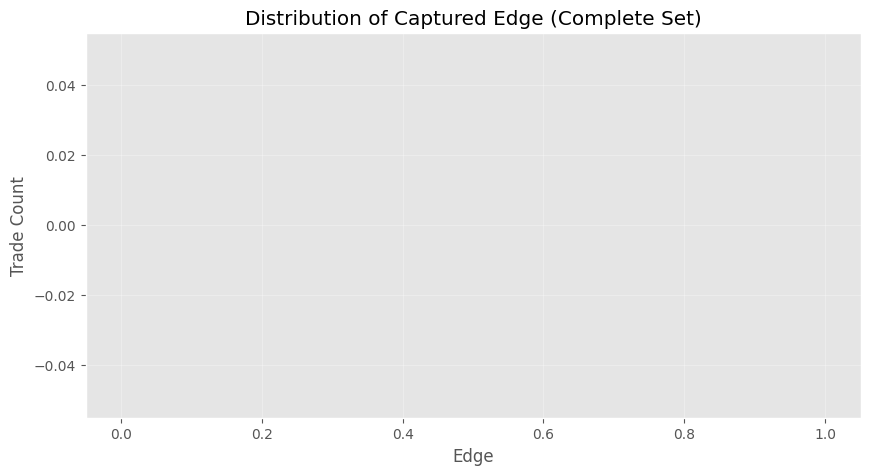

In [31]:
# Edge and PnL Analysis
if not gabagool_df.empty and 'edge' in gabagool_df.columns:
    avg_edge = gabagool_df['edge'].mean()
    print(f"Average Complete Set Edge: {avg_edge:.4f}")
    
    plt.figure(figsize=(10, 5))
    plt.hist(gabagool_df['edge'].dropna(), bins=20, color='green', alpha=0.7)
    plt.title('Distribution of Captured Edge (Complete Set)')
    plt.xlabel('Edge')
    plt.ylabel('Trade Count')
    plt.grid(True, alpha=0.3)
    plt.show()
